# A simple pipeline for recommending similar neuroscience datasets using knowledge graph node embeddings

In this tutorial, you will:

1. Select a Blue Brain Nexus project from which to search neuron morphology and electrophysiology recordings 
2. Prepare the metadata for knowledge graph embeddings
3. Train a knowledge graph node embedding model and embed each neuron morphology
4. Store and index the embeddings in Blue Brain Nexus
5. Recommend similar neuron morphologies and electrophysiology recordings using the embeddings 


![Dataset recommendation](../assets/kg_embed.png)


### Prerequisites

This notebook makes use of a dataset made of mouse neuron morphologies downloaded from Allen Cell Types Database and Mouselight as well as mouse electrophysiology recordings from Allen Cell Types Database. This dataset is expected to be accessible from a Blue Brain Nexus Project to be configured below. If not, please run the "Store, manage and access neuroscience datasets from different sources with MINDS metadata and provenance" ![notebook](https://github.com/BlueBrain/nexus/blob/master/docs/src/main/paradox/docs/getting-started/notebooks/dataset_from_different_sources.ipynb).

In [ ]:
!pip install pyRDF2vec

In [ ]:
!pip install nexusforge

In [ ]:
!pip install matplotlib

## Select a Blue Brain Nexus project from which to search neuron morphology and electrophysilogy recordings

### Initialize and configure a client to access a Blue Brain Nexus Project

#### Get an authentication token

The [Nexus sandbox application](https://sandbox.bluebrainnexus.io/web) can be used to get a token.

- Step 1: From the opened web page, click on the login button on the right corner and follow the instructions.

![login-ui](../assets/login-ui.png)

- Step 2: At the end you’ll see a token button on the right corner. Click on it to copy the token.

![login-ui](../assets/copy-token.png)


Once a token is obtained then proceed to paste it below.

In [ ]:
import getpass

In [ ]:
TOKEN = getpass.getpass()

#### Configure a forge client to store, manage and access datasets

In [ ]:
from kgforge.core import KnowledgeGraphForge

In [ ]:
ENDPOINT = "https://sandbox.bluebrainnexus.io/v1"
ORG = "github-users"
PROJECT = "mfsy"  # Provide here the automatically created project name with your login when you logged in the Nexus sandbox instance.

In [ ]:
from kgforge.core import KnowledgeGraphForge

forge = KnowledgeGraphForge("forge.yml",
                            bucket=f"{ORG}/{PROJECT}",
                            endpoint=ENDPOINT,
                            token=TOKEN
                           )

### Search neuron morphology and electrophysiolgy recordings

In [ ]:
property_to_display = ["id","type","@id","@type","name","subject","brainLocation.brainRegion.id","brainLocation.brainRegion.label","brainLocation.layer.id","brainLocation.layer.label", "contribution.agent.label","brainLocation.layer.id","brainLocation.layer.label"]

#### Search neuron morphologies

In [ ]:
filters = {"type":"NeuronMorphology"}

number_of_results = 20

morphologies = forge.search(filters, limit=number_of_results)

print(str(len(morphologies))+" neuron morphologies found.")

reshaped_data = forge.reshape(morphologies, keep = property_to_display)

morphologies_df = forge.as_dataframe(reshaped_data)
morphologies_df.head()

#### Search electrophysiolgy recordings

In [ ]:
filters = {"type":"Trace"}

number_of_results = 20

ephys = forge.search(filters, limit=number_of_results)

print(str(len(ephys))+" electrophysiology found found.")

reshaped_data = forge.reshape(ephys, keep = property_to_display)

ephys_df = forge.as_dataframe(reshaped_data)
ephys_df.head()

## Prepare the metadata for knowledge graph embeddings

In this step, a clean graph data structure will be generated for the seraach results.

In [ ]:
dataset = ephys + morphologies
graph = forge.as_graph(dataset)

In [ ]:
len(graph)

In [ ]:
from pyrdf2vec.graphs import KG
from pyrdf2vec.rdf2vec import KG as rdf2vecgraph, Vertex
import pyrdf2vec.rdf2vec
import rdflib

In [ ]:
import validators

def remove_bn_from_walk(walk):
    new_walks= [item for index, item in enumerate(walk) if not (index!= 0 and validators.uuid(item)) and not str(item).startswith('N') and not str(item).startswith("b'") and not str(item).startswith('b"') and not str(item).startswith("ub") and not str(item).startswith('t') and not str(item).startswith('rdflib.term.BNode') and '_' not in str(item)]
    new_walks = tuple(new_walks)
    return new_walks

def keep_fragment(uri):
    if str(uri).startswith('http') or str(uri).startswith('file'):
        ns, fragment = rdflib.namespace.split_uri(str(uri).strip("/").strip(","))
        return fragment
    else:
        return uri


In [ ]:
from tqdm import tqdm
from rdflib.namespace import Namespace

SCHEMAORG = Namespace('http://schema.org/')

labels = {}
kg = KG()
def create_kg(kg, graph, label_predicates, source=""):    
    
    for (s, p, o) in tqdm(graph.triples((None, None, None))):
        if p == SCHEMAORG.name:
            s_type = graph.objects(s, rdflib.namespace.RDF.type)
            _type = ""
            for t in s_type:
                _type = _type+"_"+keep_fragment(str(t))
            
            labels[keep_fragment(str(s))] = _type+"_"+"_"+source+"_"+str(o)+"_"+keep_fragment(str(s))
        if str(p) not in property_to_skip and p not in label_predicates:    
            s_v = Vertex(keep_fragment(str(s)))
            o_v = Vertex(keep_fragment(str(o)))
            p_v = Vertex(keep_fragment(str(p)), predicate=True, vprev=s_v, vnext=o_v)
            kg.add_vertex(s_v)
            kg.add_vertex(p_v)
            kg.add_vertex(o_v)
            kg.add_edge(s_v, p_v)
            kg.add_edge(p_v, o_v)

create_kg(kg, graph, [])

In [ ]:
# Select the Neuron Morphologies and Electrophysiology recordings to build embeddings for
entity_namespace = "https://neuroshapes.org/"

type_ref = rdflib.term.URIRef(entity_namespace+"NeuronMorphology")
graph_instances = [str(main_subject) for main_subject in graph.subjects(rdflib.namespace.RDF.type, type_ref)]
type_ref_ephys = rdflib.term.URIRef(entity_namespace+"Trace")

graph_instances.extend([str(main_subject) for main_subject in graph.subjects(rdflib.namespace.RDF.type, type_ref_ephys)])

print(f"{len(graph_instances)} Neuron Morphologies and Electrophysiology recordings instances found")


## Train a knowledge graph node embedding model and embed each neuron morphology and electrophysiology recordings

A knowledge graph embedding model represents each node (e.g. each Neuron Morphology or Electrophysiology recordings) in the graph with a numerical dense vector in a low dimension space with the aim that similar nodes will be close enough in that space. How two nodes are close or similar can be computed using a distance metric such as cosine similarity between their embeding vectors.

For this tutorial, the [pyRDF2Vec]("https://github.com/IBCNServices/pyRDF2Vec") will be used to generate embeddings for the selected Neuron Morphologies or Electrophysiology recordings.

In [ ]:
from pyrdf2vec.graphs import KG
from pyrdf2vec.rdf2vec import KG as rdf2vecgraph, Vertex
import pyrdf2vec.rdf2vec
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.walkers import RandomWalker, WeisfeilerLehmanWalker, CommunityWalker, WalkletWalker, HalkWalker
from pyrdf2vec.samplers import UniformSampler, PageRankSampler, ObjFreqSampler

In [ ]:
walkers = [WeisfeilerLehmanWalker(20, 100, ObjFreqSampler())]

In [ ]:
def graph_to_text(graph,walkers, instances, unique=True):
    walks_= []
    for walker in walkers:
            all_walks = list(walker.extract(graph, instances))
           
            walks_ += all_walks
    print('Extracted {} walks for {} instances!'.format(len(walks_),
                                                            len(instances)))
    sentences = []
    for x in walks_:
        if x not in sentences:
            sentences.append(list(map(str, remove_bn_from_walk(x))))
        
    unique_sentences = []
    if unique:
        
        for s in sentences:
            if s not in unique_sentences:
                unique_sentences.append(s)
    else:
        unique_sentences = sentences

    print(f"Generated unique ({unique}) {len(sentences)} sentences without blank nodes")
    return sentences, walks_

sentences, walks = graph_to_text(kg,walkers, graph_instances, False)

In [ ]:
sentences[2]

In [ ]:
transformer_origin

In [ ]:
rdf2Vec_transformer = RDF2VecTransformer(walkers=walkers)
rdf2Vec_transformer.embedder.fit(sentences)
rdf2Vec_transformer.embedder.transform(graph_instances)

print("Done")

In [ ]:
embedding = rdf2Vec_transformer.embedder.model_.wv.get_vector("https://bbp.epfl.ch/neurosciencegraph/data/neuronmorphologies/b79a7353-a853-4790-b319-c474aec3bd34")

In [ ]:
len(embedding)

### Visualise the embeddings

/Users/mfsy/anaconda3/envs/embeddings/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


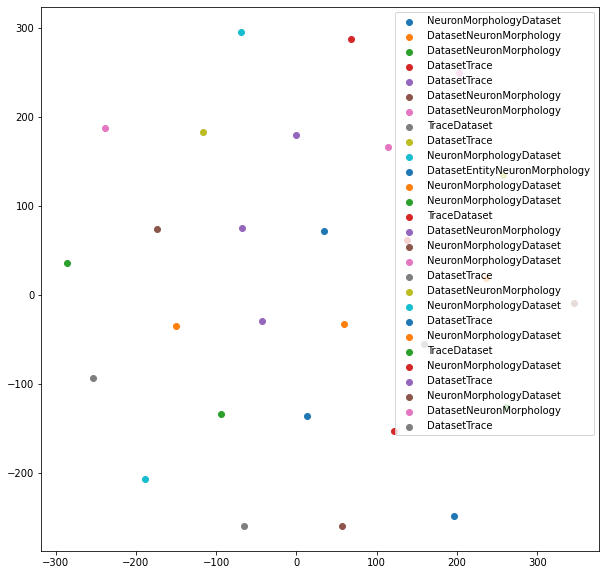

In [132]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def generate_tsne(model):
    "Creates and TSNE model and plots it"

    tokens = []
    ls=[]

    for word in model.wv.vocab:
        if word in graph_instances:
            tokens.append(model[word])
            
           
            split_tables =labels[keep_fragment(word)].split("_")
            l = "".join(split_tables[0:5])
            l = l.replace(" ","_")
            ls.append(l)
          
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=3000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        sc = plt.scatter(x[i],y[i], label=ls[i])
        plt.annotate('',
                     xy=(x[i], y[i]),
                     ha='right',
                     va='bottom')
        
    plt.legend()
    plt.show()
    
generate_tsne(rdf2Vec_transformer.embedder.model_)

### Save the embeddings vectors and metadata to disk and in the Nexus project

In [ ]:
import io
out_v = io.open(f"vectors_rdf2vec_kg_embeddings.tsv", 'w', encoding='utf-8')
out_m = io.open(f"metadata_rdf2vec_kg_embeddings.tsv", 'w', encoding='utf-8')
embeddings_matrix = []
for entity in graph_instances:

  entity_fragment = keep_fragment(entity)
  entity_label=labels[keep_fragment(entity_fragment)]
  embedding = transformer_origin.embedder.model_.wv.get_vector(str(entity))
  
  out_m.write(entity_label + "\n")
  out_v.write('\t'.join([str(x) for x in embedding]) + "\n")
  entity_resource = forge.retrieve(id=entity)
  entity_resource.embeddings = [float(x) for x in embedding]
  forge.update(entity_resource)
out_v.close()
out_m.close()

### Save the embedding model to disk

In [ ]:
rdf2Vec_transformer.embedder.model_.save("./kg_embedding_model")

## Store and index the embeddings in Blue Brain Nexus

### Create an ElasticSearchView

The goal here is to create an [Elasticsearch](https://www.elastic.co/elasticsearch/) index within the configured Nexus project in which to store and query the embeddings. Such index can be created using an [ElasticSearchView](https://bluebrainnexus.io/docs/delta/api/views/elasticsearch-view-api.html).

In [ ]:
import nexussdk as nexus

In [ ]:
view_id="https://second_dataset_recommendatation_view"
type_to_index = ["https://neuroshapes.org/NeuronMorphology","https://neuroshapes.org/Trace"]
view_data = {
    "@type": [
        "ElasticSearchView"
    ],
    "includeMetadata": True,
    "includeDeprecated": False,
    "resourceTypes":type_to_index,
    "mapping": {
        "properties": {
            "@id": {
                "type": "keyword"
            },
            "@type": {
                "type": "keyword"
            },
            "embeddings": {
                "type":"dense_vector",
                "dims":100
            }
        }
    },
    "sourceAsText": False
}

try:
    response = nexus.views.create_(org_label=ORG, project_label=PROJECT,payload=view_data,view_id=view_id)
except nexus.HTTPError as ne:
    print(ne.response.json())


## Recommend similar neuron morphologies and electrophysiology recordings using the embeddings

In [ ]:
from urllib.parse import quote_plus
#Configure forge to point to the newly created ElasticSearch view
forge._store.service.elastic_endpoint["endpoint"] = "/".join((ENDPOINT, "views", quote_plus(ORG), quote_plus(PROJECT), quote_plus(view_id), "_search"))

In [ ]:
def get_similar_movies(item_id, q="*", number_of_results=10, view_id=None):
    """
    Given a movie id, execute the recommendation function score query to find similar movies, ranked by cosine similarity
    """
    # Get the item from Nexus and retrieve its embedding
    
    item_source = forge.retrieve(id = item_id)
    
    # extract the embedding
    item_embedding = item_source.embeddings
    query = """{

          "query": {
            "script_score": {
              "query": {
                    "exists": {
                    "field": "embeddings"
                    }
              },
              "script": {
                "source": "cosineSimilarity(params.queryVector, doc['embeddings'])+1.0",
                "params": {
                  "queryVector": %s
                }
              }
            }
          }
        }""" % (item_embedding)
    results = forge.elastic(query=query, debug=False, limit=2)
    scores = [r._score for r in results if hasattr(r, "_score")]
    return [forge.from_json(dict(r._source)) for r in results if hasattr(r, "_source")], scores

In [ ]:
morphologies_df.head()

In [ ]:
# Select a morphology id to recommend similar morphologies for.
morphology_id = morphologies_df.id[0]
morphology_id

In [ ]:
number_of_results = 10
forge._debug= True
res, scores = get_similar_movies(item_id=morphology_id, 
                                 view_id=view_id,
                                number_of_results=number_of_results)
reshaped_res = forge.reshape(res, keep = property_to_display)
#reshaped_res = [r]
print(f"Found {len(res)} Datasets")
result_df = forge.as_dataframe(reshaped_res)
result_df.insert(0, "score", scores)
result_df

In [ ]:
ephys_df.head()

In [ ]:
# Select an electrophysiology recording id to recommend similar electrophysiology recordings for.
ephys_id = ephys_df.id[0]
ephys_id

In [ ]:
number_of_results = 10
forge._debug= True
res, scores = get_similar_movies(item_id=ephys_id, 
                                 view_id=view_id,
                                number_of_results=number_of_results)
reshaped_res = forge.reshape(res, keep = property_to_display)
#reshaped_res = [r]
print(f"Found {len(res)} Datasets")
result_df = forge.as_dataframe(reshaped_res)
result_df.insert(0, "score", scores)
result_df